In [5]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader

### Load in data

In [9]:
PATH_TO_TSV = r"/home/nselman/ml/drugsComTrain_raw.tsv"

In [20]:
df = pd.read_csv(PATH_TO_TSV, header=0, delimiter='\t', index_col=0, parse_dates=['date'])

Interpolate null conditions with Not Entered

In [34]:
df.loc[df['condition'].isna(), 'condition'] = 'Not Entered'

NO MORE NULLS!

In [35]:
df.isna().sum()

drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

### Bucket the ratings into (Positive, Neutral, Negative)

array([[<AxesSubplot:title={'center':'rating'}>]], dtype=object)

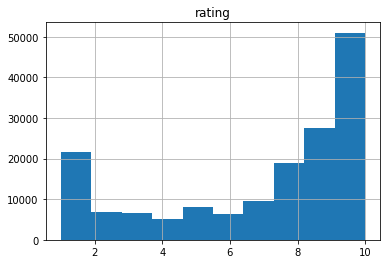

In [38]:
df.hist(column='rating')

In [40]:
df['rating'].describe()

count    161297.000000
mean          6.994377
std           3.272329
min           1.000000
25%           5.000000
50%           8.000000
75%          10.000000
max          10.000000
Name: rating, dtype: float64

Breaking our dataset into the following buckets:
- Negative: 0-3
- Neutral: 4-6
- Positive: 7-10

Positive could be divided in to 7-8, 9-10 since people based on knowledge of how reviews are given, there seems to be a meaningful difference

In [41]:
df['rating_category'] = 'Postive'
df.loc[df['rating'] < 7, 'rating_category'] = 'Neutral'
df.loc[df['rating'] < 4, 'rating_category'] = 'Negative'

### *Important Thing to Consider*
*Rating categories are very imbalanced - let's ask Amitabh if there's some sort of a strategy that will balance the types that our algorithm will see during training.  Right now our model would do well by predictive everything as positive.  Ideally we'd want each mini batch to contain examples belonging to every rating category.*


In [43]:
df['rating_category'].value_counts()

Postive     106866
Negative     35063
Neutral      19368
Name: rating_category, dtype: int64

### Convert Usefulness to Likes/Day

Since usefulness ratings are a function of how long the review has existed, this converts it to usefulness/day

Assumption:
- All reviews were scraped on the same day AND this is the same date as the most recent review
- The only factor that is correlated with the number of likes is the text of the review. (this assumption is particularly suspect because reviews that already have likes are more likely to be seen and thus may be more likely to be liked again).

In [48]:
max_date = df['date'].max()
print(max_date)
min_date = df['date'].min()

2017-12-12 00:00:00


In [58]:
(max_date - df['date']).dt.days

206461    2032
95260     2786
92703     2920
138000     770
35696      380
          ... 
191035     926
127085    2233
187382    1368
47128      815
215220    1095
Name: date, Length: 161297, dtype: int64

In [61]:
df['useful_daily'] = df['usefulCount'] / ((max_date - df['date']).dt.days + 1) # +1 to avoid any division issues

### Create Dataset Object

In [ ]:
class DrugReviewDataset(Dataset):
    def __init__(self, tsv_file):
        pass
    def __len__(self):
        pass
    def __getitem__(self, i)